# Market Regime Classification Models

**Refined LSTM/GRU implementation for S&P 500 Bull/Bear regime classification**

## Table of Contents

1. **Setup & Data Loading**
   - Environment configuration and imports
   - Loading pre-labeled market regime data

2. **Data Preparation**
   - Feature selection and data cleaning
   - Train/validation/test split (2000-2013/2013-2019/2019-2025)
   - Standardization and dimensionality reduction via PCA

3. **Sequence Generation**
   - LSTM/GRU sequence preparation (60-day lookback)
   - Class weight calculation for imbalanced datasets

4. **Model Architecture**
   - LSTM model: 2 layer 64/32 architecture with batch normalization and dropout
   - GRU model: Simplified single-layer design with aggressive regularization

5. **Training & Validation**
   - Early stopping and learning rate scheduling
   - Model checkpointing and performance tracking

6. **Evaluation & Analysis**
   - Comprehensive performance metrics
   - Prediction smoothing and threshold optimization
   - Strategy backtesting with multiple hedging levels

## Research Objectives

This study addresses **market regime classification** for the S&P 500, comparing LSTM and GRU architectures for identifying bull and bear market periods. The primary goals are:

- **Model Comparison**: LSTM vs GRU performance in financial time series
- **Risk Management**: Early detection of bear market transitions
- **Strategy Development**: Regime-switching investment strategies

## Key Methodological Improvements

- **Simplified, readable model architectures** optimized for binary classification
- **Enhanced training stability** with multiple callbacks and regularization
- **Comprehensive evaluation metrics** including balanced accuracy and AUC-ROC
- **Walk-forward validation** on out-of-sample test data (2019-2025)
- **Prediction smoothing** to reduce noise and improve practical applicability
- **Fixed random seeds** for complete reproducibility

## 1. Setup & Data Loading

### Import Dependencies

This section imports all necessary libraries for:

- **Data Handling**: pandas, numpy for data manipulation
- **Machine Learning**: scikit-learn for preprocessing and evaluation
- **Deep Learning**: TensorFlow/Keras for LSTM and GRU models
- **Visualization**: matplotlib, seaborn for plotting

**Key Configuration**: Fixed random seeds (SEED=42) ensure reproducible results across all components.

In [ ]:
# Essential imports with data collection dependencies
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

# Deep learning imports - using tensorflow.keras for TensorFlow 2.13
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryFocalCrossentropy



# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, roc_curve
)
SEED = 42 
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

/opt/anaconda3/envs/Market_class/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Loading Pre-Labeled Market Data

The dataset contains S&P 500 market data with pre-classified regime labels:

- **Bull Market (1)**: Periods of sustained market growth
- **Bear Market (0)**: Periods of significant market decline 

The data includes:
- **Price Data**: OHLCV data for S&P 500
- **Technical Indicators**: RSI, MACD, moving averages, ATR, etc.
- **Economic Indicators**: VIX, Treasury rates, DXY, commodities
- **Regime Labels**: Binary classification based on market conditions

In [112]:
import os
DATA_DIR = 'data'
MODEL_DIR = 'models'
FIGURES_DIR = 'figures' 

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [ ]:
labeled_data = pd.read_csv(os.path.join(DATA_DIR, 'labeled_data_cleaned.csv'), index_col=0, parse_dates=True)

In [ ]:
full_data_clean = labeled_data.copy()
test_labeled_data = labeled_data.copy().loc['2019-09-26':'2025-05-02']

## 2. Data Preparation

### Feature Selection and Data Cleaning

**Feature Engineering Strategy**: Remove raw OHLCV price columns to prevent data leakage while retaining derived technical indicators and economic variables.

**Excluded Features**:
- SP500_Open, SP500_High, SP500_Low, SP500_Close, SP500_Volume

**Rationale**: Raw price data would create perfect predictive signals (lookahead bias). Instead, we use technical indicators and economic variables that represent the information available to traders at decision time.

In [6]:
exclude_cols = ['SP500_Open', 'SP500_High', 'SP500_Low', 'SP500_Close', 'SP500_Volume']
cols_to_drop = [col for col in exclude_cols if col in full_data_clean.columns]
final_data = full_data_clean.drop(columns=cols_to_drop)

In [ ]:
final_data.to_csv(os.path.join(DATA_DIR, 'final_data.csv'), index=True)

### Temporal Data Splitting

**Walk-Forward Validation Approach**: Data is split chronologically to prevent future information leakage.

**Time Periods**:
- **Training**: 2000-2013 (13+ years) - Model learning phase
- **Validation**: 2013-2019 (6 years) - Hyperparameter tuning and early stopping
- **Test**: 2019-2025 (5+ years) - Out-of-sample evaluation including COVID and recent market volatility

**Critical Design Decision**: The test period includes the 2020 COVID crash, 2021-2022 bull run, and 2022 bear market, providing robust evaluation across diverse market conditions.

In [9]:
train_df = final_data.loc['2000-08-30':'2013-09-24']
val_df   = final_data.loc['2013-09-25':'2019-09-25']
test_df  = final_data.loc['2019-09-26':'2025-05-02']

print(f"Train set: {len(train_df)} samples ({train_df.index[0]} to {train_df.index[-1]})")
print(f"Val set: {len(val_df)} samples ({val_df.index[0]} to {val_df.index[-1]})")
print(f"Test set: {len(test_df)} samples ({test_df.index[0]} to {test_df.index[-1]})")

Train set: 3245 samples (2000-08-30 00:00:00 to 2013-09-24 00:00:00)
Val set: 1494 samples (2013-09-25 00:00:00 to 2019-09-25 00:00:00)
Test set: 1393 samples (2019-09-26 00:00:00 to 2025-05-01 00:00:00)


In [10]:
# Feature columns (excluding Regime_Label and raw SP500 data)
FEATURE_COLS = [
    'VIX', 'Treasury_10Y', 'Treasury_2Y', 'DXY', 'WTI_Crude', 'Gold',
    'SP500_Log_Volume', 'SP500_Range', 'SP500_Log_Returns',
    'SP500_MA_5', 'SP500_MA_10', 'SP500_SMA_5', 'SP500_SMA_10',
    'SP500_RSI', 'SP500_MACD', 'SP500_MACD_Signal', 'SP500_ATR',
    'SP500_MTM1', 'SP500_MTM3', 'SP500_WPR', 'SP500_SRA_5', 'SP500_SRA_10'
]

X_train = train_df[FEATURE_COLS]
X_val   = val_df[FEATURE_COLS]
X_test  = test_df[FEATURE_COLS]

# Extract regime labels
y_train = train_df['Regime_Label'].astype(int).to_numpy()
y_val   = val_df  ['Regime_Label'].astype(int).to_numpy()
y_test  = test_df ['Regime_Label'].astype(int).to_numpy()

print(f"Feature matrix shapes: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Label shapes: Train {y_train.shape}, Val {y_val.shape}, Test {y_test.shape}")
print(f"Regime Label distribution - Train: Bull={np.sum(y_train==1)}, Bear={np.sum(y_train==0)}")
print(f"Regime Label distribution - Val: Bull={np.sum(y_val==1)}, Bear={np.sum(y_val==0)}")
print(f"Regime Label distribution - Test: Bull={np.sum(y_test==1)}, Bear={np.sum(y_test==0)}")

Feature matrix shapes: Train (3245, 22), Val (1494, 22), Test (1393, 22)
Label shapes: Train (3245,), Val (1494,), Test (1393,)
Regime Label distribution - Train: Bull=2328, Bear=917
Regime Label distribution - Val: Bull=1048, Bear=446
Regime Label distribution - Test: Bull=1102, Bear=291


### Feature Standardization

**StandardScaler Application**: Features are normalized to have zero mean and unit variance.

**Key Principles**:
- **Fit only on training data** to prevent data leakage
- **Transform all sets** using training statistics
- **Preserve temporal structure** by maintaining original indices


In [11]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only
scaler = StandardScaler().fit(X_train)

# Transform data and convert back to DataFrames with original index and columns
X_train_std = pd.DataFrame(
    scaler.transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)

X_val_std = pd.DataFrame(
    scaler.transform(X_val),
    index=X_val.index,
    columns=X_val.columns
)

X_test_std = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

print(f"✅ StandardScaler fitted on training data")
print(f"Scaled feature means (should be ~0): {X_train_std.mean().iloc[:5].tolist()}")
print(f"Scaled feature stds (should be ~1): {X_train_std.std().iloc[:5].tolist()}")



✅ StandardScaler fitted on training data
Scaled feature means (should be ~0): [-1.7517232314578742e-16, -1.4013785851662993e-16, 7.006892925831497e-17, 0.0, 7.006892925831497e-17]
Scaled feature stds (should be ~1): [1.0001541188265297, 1.0001541188265297, 1.0001541188265297, 1.0001541188265297, 1.0001541188265297]


## PCA Analysis: Variance Explained and Feature Contributions

### Understanding Principal Components in Financial Data

This comprehensive analysis reveals how the original 22 financial features combine into 10 principal components, providing insights into the underlying structure of market regime indicators.

**Analysis Components**:
1. **Individual Variance Explained**: How much information each PC captures
2. **Cumulative Variance**: Progressive information retention
3. **Feature Loadings**: Which original features drive each PC
4. **Visualizations**: Heatmaps and contribution charts



In [12]:
# Fit PCA(n_components=N_PCA) on the scaled train predictors only;  N_PCA = 0.95
pca = PCA(n_components=10, svd_solver='full').fit(X_train_std)

# First transform the data (keep these as intermediate variables)
X_train_pc_array = pca.transform(X_train_std)
X_val_pc_array = pca.transform(X_val_std)
X_test_pc_array = pca.transform(X_test_std)

# Create meaningful column names for principal components
pc_columns = [f"PC{i+1}" for i in range(X_train_pc_array.shape[1])]

# Convert to DataFrames with original datetime indices
X_train_pc = pd.DataFrame(
    X_train_pc_array,
    index=X_train_std.index,
    columns=pc_columns
)

X_val_pc = pd.DataFrame(
    X_val_pc_array,
    index=X_val_std.index,
    columns=pc_columns
)

X_test_pc = pd.DataFrame(
    X_test_pc_array,
    index=X_test_std.index,
    columns=pc_columns
)

k = X_train_pc.shape[1]   # number of PCs retained
print(f"Number of principal components retained (k): {k}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PC shapes: Train {X_train_pc.shape}, Val {X_val_pc.shape}, Test {X_test_pc.shape}")
print(f"\nFirst few rows of training PCA data:")
print(X_train_pc.head())

Number of principal components retained (k): 10
Explained variance ratio: 0.9605
PC shapes: Train (3245, 10), Val (1494, 10), Test (1393, 10)

First few rows of training PCA data:
                 PC1       PC2       PC3       PC4       PC5       PC6  \
Date                                                                     
2000-08-30  1.911123 -2.704863  3.858681  1.149487 -1.827519  0.685496   
2000-08-31  2.078834 -2.715002  3.320447  1.941698 -1.446139  0.553065   
2000-09-01  2.121170 -2.824246  3.593801  1.571494 -1.456568  0.822301   
2000-09-05  1.419915 -2.249735  4.078054  0.707208 -1.891735  0.776162   
2000-09-06  0.653534 -1.681067  4.491186  0.238165 -1.735571  0.715093   

                 PC7       PC8       PC9      PC10  
Date                                                
2000-08-30  0.635355  0.005455  0.030695 -0.051052  
2000-08-31  1.606323 -0.011642  0.160896 -0.328328  
2000-09-01  0.862067  0.210469  0.097430 -0.204419  
2000-09-05  0.678414  0.382975  0.16

In [ ]:
# Individual Variance Explained by Each Principal Component
print("=== INDIVIDUAL VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT ===")
print(f"Total Components Retained: {len(pca.explained_variance_ratio_)}")
print(f"Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
print("\nVariance explained by each component:")
print("-" * 50)

for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1:2d}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

# Cumulative variance
print("\n=== CUMULATIVE VARIANCE EXPLAINED ===")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("-" * 50)
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-PC{i+1:2d}: {cum_var:.4f} ({cum_var*100:.2f}%)")

=== INDIVIDUAL VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT ===
Total Components Retained: 10
Total Variance Explained: 0.9605 (96.05%)

Variance explained by each component:
--------------------------------------------------
PC 1: 0.3427 (34.27%)
PC 2: 0.2133 (21.33%)
PC 3: 0.1677 (16.77%)
PC 4: 0.0884 (8.84%)
PC 5: 0.0429 (4.29%)
PC 6: 0.0325 (3.25%)
PC 7: 0.0284 (2.84%)
PC 8: 0.0174 (1.74%)
PC 9: 0.0157 (1.57%)
PC10: 0.0116 (1.16%)

=== CUMULATIVE VARIANCE EXPLAINED ===
--------------------------------------------------
PC1-PC 1: 0.3427 (34.27%)
PC1-PC 2: 0.5559 (55.59%)
PC1-PC 3: 0.7237 (72.37%)
PC1-PC 4: 0.8120 (81.20%)
PC1-PC 5: 0.8549 (85.49%)
PC1-PC 6: 0.8874 (88.74%)
PC1-PC 7: 0.9158 (91.58%)
PC1-PC 8: 0.9332 (93.32%)
PC1-PC 9: 0.9489 (94.89%)
PC1-PC10: 0.9605 (96.05%)


In [ ]:
# Feature Loadings Analysis - Which original features contribute most to each PC
print("\n=== FEATURE LOADINGS FOR EACH PRINCIPAL COMPONENT ===")
print("(Shows which original features contribute most to each PC)\n")

feature_names = FEATURE_COLS
loadings_df = pd.DataFrame(
    pca.components_.T,  # Transpose to get features as rows, PCs as columns
    columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    index=feature_names
)

# Show loadings for each PC
for i in range(len(pca.explained_variance_ratio_)):
    pc_name = f'PC{i+1}'
    print(f"\n{pc_name} - Explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance")
    print("-" * 60)
    
    # Get absolute loadings and sort by importance
    pc_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
    
    print("Top 5 contributing features:")
    for j, (feature, loading) in enumerate(pc_loadings.head().items()):
        original_loading = loadings_df.loc[feature, pc_name]  # Get original sign
        print(f"  {j+1}. {feature:20s}: {original_loading:7.3f} (|{loading:.3f}|)")
    
    if len(pc_loadings) > 5:
        print(f"  ... and {len(pc_loadings)-5} other features")


=== FEATURE LOADINGS FOR EACH PRINCIPAL COMPONENT ===
(Shows which original features contribute most to each PC)


PC1 - Explains 34.27% of variance
------------------------------------------------------------
Top 5 contributing features:
  1. SP500_MACD          :   0.296 (|0.296|)
  2. VIX                 :  -0.281 (|0.281|)
  3. SP500_MTM3          :   0.279 (|0.279|)
  4. SP500_MACD_Signal   :   0.278 (|0.278|)
  5. SP500_MTM1          :   0.268 (|0.268|)
  ... and 17 other features

PC2 - Explains 21.33% of variance
------------------------------------------------------------
Top 5 contributing features:
  1. WTI_Crude           :   0.359 (|0.359|)
  2. Gold                :   0.346 (|0.346|)
  3. SP500_Log_Volume    :   0.334 (|0.334|)
  4. Treasury_10Y        :  -0.283 (|0.283|)
  5. DXY                 :  -0.281 (|0.281|)
  ... and 17 other features

PC3 - Explains 16.77% of variance
------------------------------------------------------------
Top 5 contributing features:
  1.

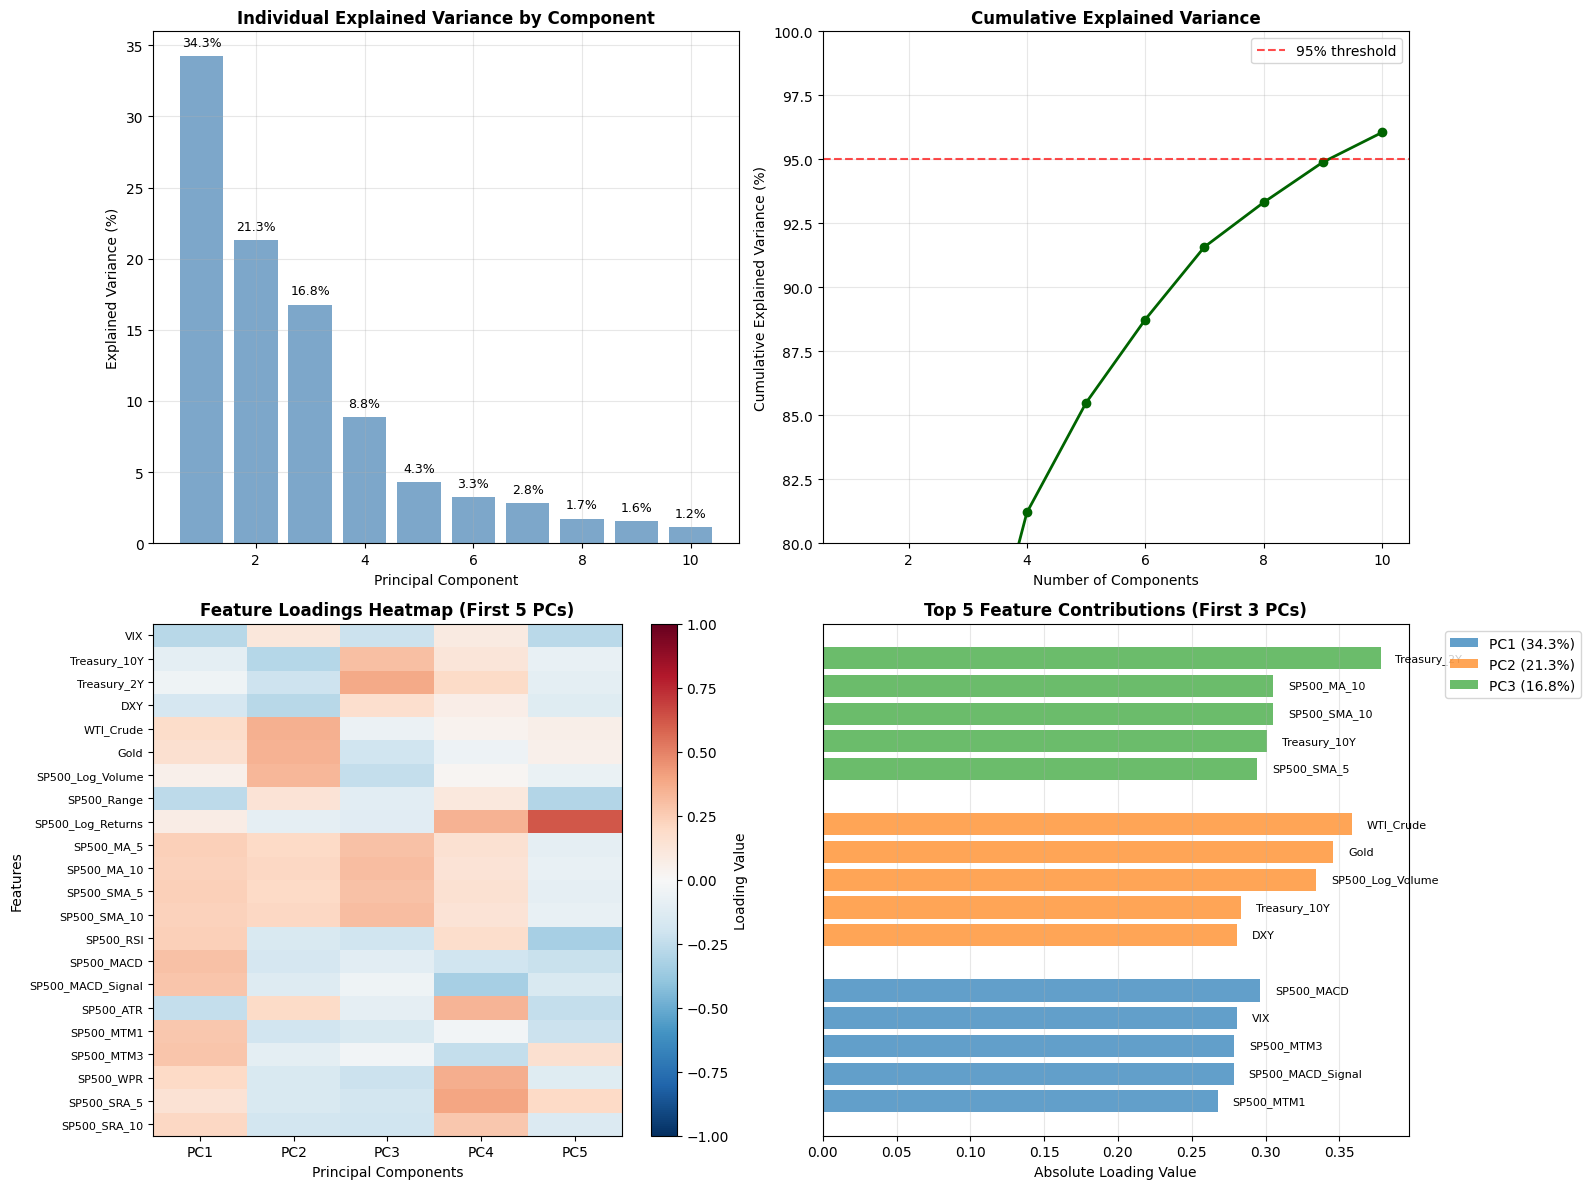

In [15]:
# 3. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Individual explained variance ratio
pc_numbers = range(1, len(pca.explained_variance_ratio_) + 1)
axes[0,0].bar(pc_numbers, pca.explained_variance_ratio_ * 100, alpha=0.7, color='steelblue')
axes[0,0].set_title('Individual Explained Variance by Component', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Explained Variance (%)')
axes[0,0].grid(True, alpha=0.3)
for i, v in enumerate(pca.explained_variance_ratio_ * 100):
    axes[0,0].text(i+1, v+0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axes[0,1].plot(pc_numbers, cumulative_variance * 100, 'o-', linewidth=2, markersize=6, color='darkgreen')
axes[0,1].axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
axes[0,1].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('Cumulative Explained Variance (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_ylim([80, 100])

# Plot 3: Feature loadings heatmap for first 5 PCs
if len(pca.explained_variance_ratio_) >= 5:
    loadings_subset = loadings_df.iloc[:, :5]  # First 5 PCs
else:
    loadings_subset = loadings_df

im = axes[1,0].imshow(loadings_subset.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_title('Feature Loadings Heatmap (First 5 PCs)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Principal Components')
axes[1,0].set_ylabel('Features')
axes[1,0].set_xticks(range(loadings_subset.shape[1]))
axes[1,0].set_xticklabels(loadings_subset.columns)
axes[1,0].set_yticks(range(len(feature_names)))
axes[1,0].set_yticklabels(feature_names, fontsize=8)
plt.colorbar(im, ax=axes[1,0], label='Loading Value')

# Plot 4: Top feature contributions for first 3 PCs
n_pcs_to_show = min(3, len(pca.explained_variance_ratio_))
for i in range(n_pcs_to_show):
    pc_loadings = loadings_df.iloc[:, i].abs().sort_values(ascending=True).tail(5)
    y_pos = np.arange(len(pc_loadings)) + i * 6
    
    axes[1,1].barh(y_pos, pc_loadings.values, alpha=0.7, 
                   label=f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}%)')
    
    for j, (feature, loading) in enumerate(pc_loadings.items()):
        axes[1,1].text(loading + 0.01, y_pos[j], feature, 
                       va='center', ha='left', fontsize=8)

axes[1,1].set_title('Top 5 Feature Contributions (First 3 PCs)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Absolute Loading Value')
axes[1,1].set_yticks([])
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [16]:
# 4. Display the complete loadings matrix as a DataFrame for detailed inspection
print("\n=== COMPLETE FEATURE LOADINGS MATRIX ===")
print("(Rows = Original Features, Columns = Principal Components)")
print("(Values show how much each original feature contributes to each PC)\n")

# Round for better readability
loadings_display = loadings_df.round(3)
print(loadings_display.to_string())

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Total original features: {len(feature_names)}")
print(f"Principal components retained: {len(pca.explained_variance_ratio_)}")
print(f"Dimensionality reduction: {len(feature_names)} → {len(pca.explained_variance_ratio_)} ({len(pca.explained_variance_ratio_)/len(feature_names)*100:.1f}% of original size)")
print(f"Variance preserved: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Variance lost: {(1-pca.explained_variance_ratio_.sum())*100:.2f}%")


=== COMPLETE FEATURE LOADINGS MATRIX ===
(Rows = Original Features, Columns = Principal Components)
(Values show how much each original feature contributes to each PC)

                     PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10
VIX               -0.281  0.117 -0.212  0.088 -0.269  0.072  0.168  0.144 -0.056  0.017
Treasury_10Y      -0.101 -0.283  0.301  0.125 -0.073 -0.408  0.054  0.084  0.049  0.045
Treasury_2Y       -0.041 -0.205  0.378  0.189 -0.100 -0.424  0.061  0.073 -0.063 -0.020
DXY               -0.165 -0.281  0.171  0.066 -0.125  0.530  0.141  0.120  0.119  0.057
WTI_Crude          0.181  0.359 -0.062  0.032  0.062 -0.240 -0.076  0.019 -0.116  0.001
Gold               0.159  0.346 -0.202 -0.049  0.051  0.209 -0.033 -0.015  0.019  0.009
SP500_Log_Volume   0.054  0.334 -0.236  0.019 -0.065 -0.445  0.128  0.170  0.055  0.053
SP500_Range       -0.260  0.139 -0.106  0.108 -0.290 -0.041  0.401  0.109  0.336 -0.058
SP500_Log_Returns  0.073 -0.088 -0.116

# Sequence Generation for LSTM/GRU Models

### Sequential Data Preparation

**Sequence Architecture**: Transform tabular data into temporal sequences suitable for recurrent neural networks.

**Configuration Parameters**:
- **LOOKBACK**: 60 trading days (~3 months) of historical context
- **Label Shift**: 0 (classify current day's regime)
- **Sequence Shape**: (batch_size, 60, 10) - 60 time steps × 10 features

**Temporal Logic**: For each trading day t, create a sequence from days [t-59, t-58, ..., t-1, t] to predict the regime at day t.

**Why 60 Days?**: Represents approximately 3 months of trading data, capturing both short-term market momentum and medium-term trend changes that typically drive regime transitions.

**Output**: X_seq contains sequences, y_seq contains corresponding regime labels (0=Bear, 1=Bull).

In [ ]:
def build_sequences(X_pc, y, lookback=60, label_shift=0):
    """
    Build sequences for LSTM/GRU training
    
    Parameters:
    - X_pc: Principal components array (n_samples, k)
    - y: Labels array (n_samples,)
    - lookback: Number of previous days to look back (100)
    - label_shift: Label shift (0 = classify current day)
    
    Returns:
    - X_seq: Sequences array (n_sequences, lookback, k)
    - y_seq: Labels array (n_sequences,)
    """
    n_samples, n_features = X_pc.shape
    
    # Calculate number of valid sequences
    start_idx = lookback - 1
    n_sequences = n_samples - start_idx - label_shift
    
    if n_sequences <= 0:
        raise ValueError(f"Not enough samples for sequences. Need at least {lookback + label_shift}")
    
    # Initialize arrays
    X_seq = np.zeros((n_sequences, lookback, n_features))
    y_seq = np.zeros(n_sequences)
    
    # Build sequences
    for i in range(n_sequences):
        actual_idx = i + start_idx
        # Sequence from [i : i + lookback]
        X_seq[i] = X_pc[actual_idx - lookback + 1 : actual_idx + 1]
        # Label at actual_idx + label_shift
        y_seq[i] = y[actual_idx + label_shift]
    
    return X_seq, y_seq

LOOKBACK = 60
label_shift = 0
print(f"Sequence parameters: LOOKBACK={LOOKBACK}, label_shift={label_shift}")

Sequence parameters: LOOKBACK=60, label_shift=0


In [ ]:
# For each date t build a 60 × k matrix from X_pc[t-59 : t]; label = regime_label[t]
# Produce X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq

print("Building sequences for train set...")
X_train_seq, y_train_seq = build_sequences(X_train_pc_array, y_train, LOOKBACK, label_shift)

print("Building sequences for validation set...")
X_val_seq, y_val_seq = build_sequences(X_val_pc_array, y_val, LOOKBACK, label_shift)

print("Building sequences for test set...")
X_test_seq, y_test_seq = build_sequences(X_test_pc_array, y_test, LOOKBACK, label_shift)

print(f"\nSequence shapes:")
print(f"Train: X_seq {X_train_seq.shape}, y_seq {y_train_seq.shape}")
print(f"Val:   X_seq {X_val_seq.shape}, y_seq {y_val_seq.shape}")
print(f"Test:  X_seq {X_test_seq.shape}, y_seq {y_test_seq.shape}")

print(f"\nRegime distribution in sequences:")
print(f"Train - Bull: {(y_train_seq==1).sum()}, Bear: {(y_train_seq==0).sum()}")
print(f"Val   - Bull: {(y_val_seq==1).sum()}, Bear: {(y_val_seq==0).sum()}")
print(f"Test  - Bull: {(y_test_seq==1).sum()}, Bear: {(y_test_seq==0).sum()}")

Building sequences for train set...
Building sequences for validation set...
Building sequences for test set...

Sequence shapes:
Train: X_seq (3186, 60, 10), y_seq (3186,)
Val:   X_seq (1435, 60, 10), y_seq (1435,)
Test:  X_seq (1334, 60, 10), y_seq (1334,)

Regime distribution in sequences:
Train - Bull: 2328, Bear: 858
Val   - Bull: 989, Bear: 446
Test  - Bull: 1043, Bear: 291


# Addressing Class Imbalance

### Balanced Class Weights for Market Regime Data

**Challenge**: Financial markets spend more time in bull regimes than bear regimes, creating an imbalanced dataset.

**Solution**: Implement weighted loss function that increases importance of minority class (bear markets).

**Class Weight Strategy**:
- **Base Weights**: Sklearn's 'balanced' approach (inversely proportional to class frequency)
- **Bear Multiplier**: Additional 2.0x weight for bear class to emphasize detection
- **Practical Impact**: Model penalized more heavily for missing bear markets than bull markets

**Risk Management Rationale**: In portfolio management, failing to detect bear markets is more costly than occasional false bear signals, justifying the asymmetric loss weighting.

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def get_class_weights(y_true, multiplier):
    """
    Calculates class weights for model training, applying a custom multiplier 
    to the minority class (Bear, class 0).
    
    Args:
        y_true (np.array): The true training labels.
        multiplier (float): The factor to increase the weight of the Bear class.
        
    Returns:
        dict: A dictionary of class weights for use in model.fit().
    """
    # Calculate standard balanced weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_true),
        y=y_true
    )
    
    # Apply the custom multiplier to the bear class (class 0)
    class_weights[0] *= multiplier
    
    # Return the weights as a dictionary
    return {i: weight for i, weight in enumerate(class_weights)}

# Model Architectures

## LSTM vs GRU: Architectural Comparison

Both models are designed for binary market regime classification with careful attention to financial time series characteristics.

**Common Design Principles**:
- **Input Shape**: (60, 10) - 60 time steps × 10 principal components
- **Output**: Single sigmoid neuron for binary classification (0=Bear, 1=Bull)
- **Regularization**: Dropout and L2 regularization to prevent overfitting
- **Optimization**: Adam optimizer with conservative learning rates

**Key Differences**:

| Feature | LSTM | GRU |
|---------|------|-----|
| **Architecture** | 2 layers, 64+32 units | Single layer, 16 units |
| **Complexity** | Higher parameter count | Streamlined design |
| **Regularization** | Batch normalization + dropout | Aggressive dropout (30%) |


In [ ]:
tf.keras.backend.clear_session() 
SEED = 42  
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
#LSTM model architecture
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, dropout=0.3, recurrent_dropout=0.3)(x)
    x = BatchNormalization()(x)
    x= Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid', kernel_regularizer=l2(2e-4))(x)
    
    model = Model(inputs, out)
 
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

input_shape = (LOOKBACK, k) # k is the number of principal components
enhanced_lstm2= create_lstm_model(input_shape)
enhanced_lstm2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            19200     
                                                                 
 batch_normalization (Batch  (None, 60, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                            

## GRU Model Architecture

### Design Philosophy

The GRU model serves as a computationally efficient alternative to the LSTM, designed specifically for the binary market regime classification task. The architecture prioritizes simplicity and generalization over complexity.

### Key Architectural Decisions

**Single-Layer Design**: Unlike the 2 layer LSTM approach, the GRU employs a single recurrent layer with 16 units. This constraint forces the model to learn essential temporal patterns while reducing overfitting risk on limited financial data.

**Aggressive Regularization**: Both standard and recurrent dropout rates are set to 30%, reflecting the noisy nature of financial time series. This high regularization ensures the model captures genuine regime patterns rather than random market fluctuations.

**Class Imbalance Handling**: The training incorporates a 2.0 multiplier for bear market class weights, emphasizing the critical importance of detecting minority bear market periods for risk management applications.

**Simplified Output**: A single sigmoid neuron with L2 regularization (1e-4) produces binary classification probabilities, maintaining focus on the core regime classification objective.



In [22]:
# GRU Model Architecture
def create_gru_model(input_shape):
    """Create GRU model with identical architecture to LSTM (swap LSTM with GRU)"""
    inputs = Input(shape=input_shape)
    x =    GRU(16, return_sequences=False, dropout=0.30, recurrent_dropout=0.3)(inputs)
    out = (Dense(1, activation='sigmoid',kernel_regularizer=l2(1e-4))(x))
    
    model = Model(inputs, out)
    model.compile(optimizer=Adam(1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
    return model

# Create GRU model
input_shape = (LOOKBACK, k)
gru_model_final4= create_gru_model(input_shape)

print("GRU Model Architecture:")
gru_model_final4.summary()

GRU Model Architecture:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 gru (GRU)                   (None, 16)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1361 (5.32 KB)
Trainable params: 1361 (5.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




# Model Training & Validation

### Training Strategy and Callbacks


**Key Training Components**:

1. **Early Stopping**: Monitors validation AUC, stops training when performance plateaus
   - Patience: 5-7 epochs (prevents premature stopping)
   - Restores best weights automatically

2. **Learning Rate Scheduling**: Adaptive learning rate reduction
   - Reduces LR by 50% when validation loss stagnates
   - Minimum LR: 1e-7 (prevents vanishing gradients)

3. **Model Checkpointing**: Saves best performing models
   - LSTM: Monitors validation AUC (maximization)
   - GRU: Monitors validation loss (minimization)

**Training Parameters**:
- **Batch Size**: 32 (balance between stability and memory efficiency)
- **Max Epochs**: 100 (early stopping typically triggers around 20-40 epochs)
- **Class Weights**: 2.0x multiplier for bear markets


In [ ]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,  
    restore_best_weights=True,
    min_delta=0.01,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoints
lstm_checkpoint = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'best_lstm_model_final_test.h5'),
    monitor='val_auc',
    save_best_only=True,
    verbose=1
)
gru_checkpoint = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'best_gru_model_final6.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("Callbacks configured:")
print(f"- EarlyStopping: patience=10, restore_best_weights=True")
print(f"- ReduceLROnPlateau: patience=5, factor=0.5")
print(f"- ModelCheckpoint: save best models to models/")

Callbacks configured:
- EarlyStopping: patience=10, restore_best_weights=True
- ReduceLROnPlateau: patience=5, factor=0.5
- ModelCheckpoint: save best models to models/


In [ ]:
# Fit LSTM model on train, validate on X_val_seq
print("\n" + "="*60)
print("TRAINING LSTM MODEL")
print("="*60)

batch_size = 32
epochs = 100
cw_lstm = get_class_weights(y_train_seq, multiplier=2.0)


# Train LSTM model
lstm_history = enhanced_lstm2.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=cw_lstm,
    callbacks=[early_stopping, reduce_lr, lstm_checkpoint],
    verbose=1
)

print(f"\nLSTM training completed!")
print(f"Best validation loss: {min(lstm_history.history['val_loss']):.4f}")
print(f"Final training accuracy: {lstm_history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {lstm_history.history['val_accuracy'][-1]:.4f}")


TRAINING LSTM MODEL
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.8933 - accuracy: 0.6329 - precision: 0.8676 - recall: 0.5865 - auc: 0.7426
Epoch 1: val_auc improved from inf to 0.77688, saving model to /Users/makaki/Documents/Model_licencjat_lstm_gru/My_work/models/best_lstm_model_final_test.h5
100/100 [==============================] - 8s 58ms/step - loss: 0.8911 - accuracy: 0.6337 - precision: 0.8686 - recall: 0.5876 - auc: 0.7431 - val_loss: 0.6015 - val_accuracy: 0.7470 - val_precision: 0.8111 - val_recall: 0.8251 - val_auc: 0.7769 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7407 - precision: 0.9557 - recall: 0.6765 - auc: 0.8865
Epoch 2: val_auc did not improve from 0.77688
100/100 [==============================] - 6s 64ms/step - loss: 0.5859 - accuracy: 0.7407 - precision: 0.9557 - recall: 0.6765 - auc: 0.8865 - val_loss: 0.5493 - val_accuracy: 0.7261 - val_precision: 0.8098 - val_reca

In [25]:
# Train GRU model
print("\n" + "="*60)
print("TRAINING GRU MODEL")
print("="*60)

# Reset callbacks for GRU training
early_stopping_gru = EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr_gru = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
    cooldown=3
)
cw_gru = get_class_weights(y_train_seq, multiplier=2.0)
# Train GRU model
gru_history = gru_model_final4.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=cw_gru,
    callbacks=[early_stopping_gru, reduce_lr_gru, gru_checkpoint],
    verbose=1
)

print(f"\nGRU training completed!")
print(f"Best validation loss: {min(gru_history.history['val_loss']):.4f}")
print(f"Final training accuracy: {gru_history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {gru_history.history['val_accuracy'][-1]:.4f}")


TRAINING GRU MODEL
Epoch 1/100
 98/100 [============================>.] - ETA: 0s - loss: 1.0713 - accuracy: 0.5277 - precision: 0.7488 - recall: 0.5304 - auc: 0.5647
Epoch 1: val_loss improved from inf to 1.14281, saving model to /Users/makaki/Documents/Model_licencjat_lstm_gru/My_work/models/best_gru_model_final6.h5
100/100 [==============================] - 2s 14ms/step - loss: 1.0664 - accuracy: 0.5292 - precision: 0.7512 - recall: 0.5318 - auc: 0.5665 - val_loss: 1.1428 - val_accuracy: 0.3108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7420 - lr: 1.0000e-04
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5603 - precision: 0.7917 - recall: 0.5412 - auc: 0.6362
Epoch 2: val_loss improved from 1.14281 to 1.07502, saving model to /Users/makaki/Documents/Model_licencjat_lstm_gru/My_work/models/best_gru_model_final6.h5
100/100 [==============================] - 2s 17ms/step - loss: 0.9880 - accuracy: 0.5606 - precision: 

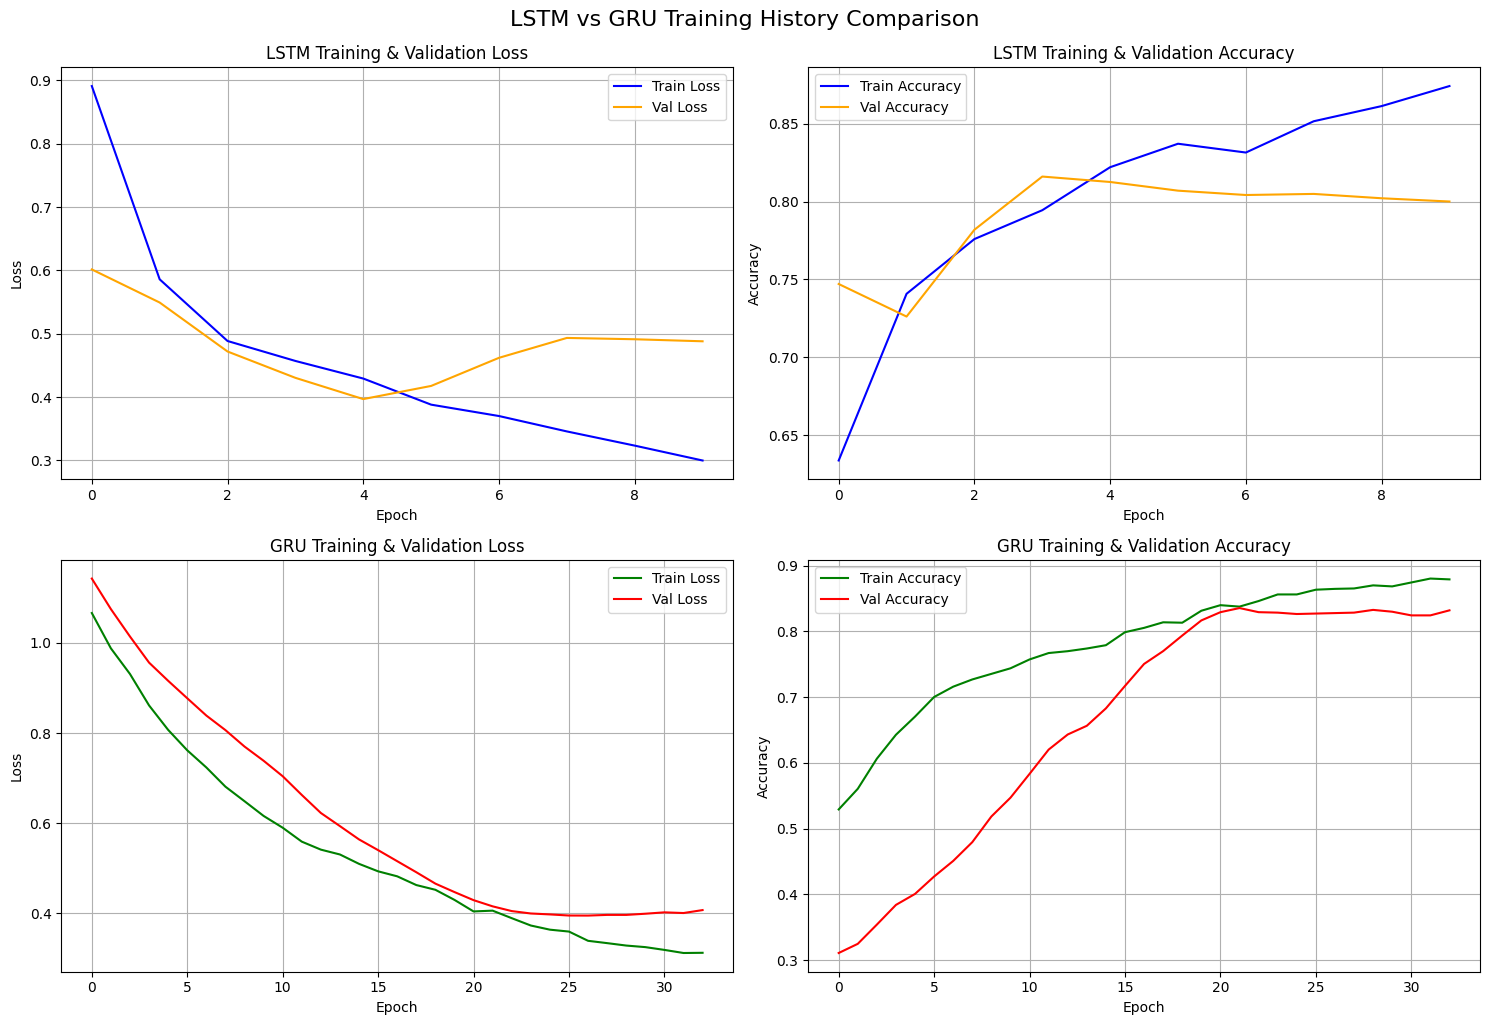


Training Summary:
LSTM - Epochs trained: 10
GRU  - Epochs trained: 33


In [71]:
# Plot training history for both models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# LSTM Training History
axes[0, 0].plot(lstm_history.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('LSTM Training & Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(lstm_history.history['accuracy'], label='Train Accuracy', color='blue')
axes[0, 1].plot(lstm_history.history['val_accuracy'], label='Val Accuracy', color='orange')
axes[0, 1].set_title('LSTM Training & Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# GRU Training History
axes[1, 0].plot(gru_history.history['loss'], label='Train Loss', color='green')
axes[1, 0].plot(gru_history.history['val_loss'], label='Val Loss', color='red')
axes[1, 0].set_title('GRU Training & Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(gru_history.history['accuracy'], label='Train Accuracy', color='green')
axes[1, 1].plot(gru_history.history['val_accuracy'], label='Val Accuracy', color='red')
axes[1, 1].set_title('GRU Training & Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.suptitle('LSTM vs GRU Training History Comparison', fontsize=16, y=1.02)
plt.show()

print(f"\nTraining Summary:")
print(f"LSTM - Epochs trained: {len(lstm_history.history['loss'])}")
print(f"GRU  - Epochs trained: {len(gru_history.history['loss'])}")

# Evaluation

## Comprehensive Model Evaluation

### Multi-Faceted Performance Assessment

**Evaluation Philosophy**: Financial models require evaluation beyond simple accuracy due to class imbalance and asymmetric costs of prediction errors.

**Performance Metrics Suite**:

1. **Classification Metrics**:
   - **Accuracy**: Overall correctness
   - **Balanced Accuracy**: Accounts for class imbalance
   - **Precision**: Reliability of bear market predictions
   - **Recall**: Ability to detect bear markets
   - **F1-Score**: Harmonic mean of precision and recall
   - **AUC-ROC**: Discrimination ability across thresholds

2. **Prediction Enhancement**:
   - **Threshold Optimization**: F1-maximizing thresholds on validation set
   - **Smoothing Filter**: 10-day rolling average to reduce noise
   - **Temporal Consistency**: Reduces prediction volatility

3. **Financial Evaluation**:
   - **Strategy Backtesting**: Multiple hedging levels (20%-100%)
   - **Risk-Return Analysis**: Comparison with buy-and-hold


This section implements:
1. Accuracy, precision, recall, F1, ROC-AUC on the test set
2. Plot soft-prob P_bear = y_pred[:,1] vs. actual bear days
3. Confusion matrix heatmap
4. Compare against persistence baseline (today's regime = yesterday's)
5. Optional: simple strategy back-test (stay long in bull, flat in bear) vs. buy-and-hold

### Prediction Enhancement Pipeline

**Step 1: Threshold Optimization**
- Find optimal F1-score thresholds on validation set
- Separate thresholds for LSTM and GRU models
- Maximizes balance between precision and recall

**Step 2: Prediction Smoothing**
- Apply 10-day rolling average to raw probabilities
- Reduces noise and false regime switches
- Maintains responsiveness to genuine regime changes

**Step 3: Strategy Implementation**
- Multiple hedging levels tested (20% to 100%)
- Bear markets: Reduce equity exposure by hedging percentage
- Bull markets: Maintain full equity exposure


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    balanced_accuracy_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)
# Evaluate LSTM model on test set
print("\n" + "="*60)
print("FINAL MODEL EVALUATION (WITH ROLLING WINDOW SMOOTHING)")
print("="*60)

# Load the saved model weights
enhanced_lstm2.load_weights(os.path.join(MODEL_DIR, 'best_lstm_model_final_test.h5'))
gru_model_final4.load_weights(os.path.join(MODEL_DIR, 'best_gru_model_final6.h5'))

# Get probability predictions on validation set for threshold tuning
print("Finding optimal thresholds on validation set...")
y_val_pred_proba_lstm = enhanced_lstm2.predict(X_val_seq, verbose=0).flatten()
y_val_pred_proba_gru = gru_model_final4.predict(X_val_seq, verbose=0).flatten()

def find_optimal_f1_threshold(y_true, y_pred_proba):
    """
    Finds the optimal threshold that maximizes the F1-score on the validation set.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_ix = np.argmax(f1_scores)
    best_threshold = thresholds[best_ix] if best_ix < len(thresholds) else 0.5
    return best_threshold

# Find optimal F1 thresholds
best_threshold_lstm = find_optimal_f1_threshold(y_val_seq, y_val_pred_proba_lstm)
best_threshold_gru = find_optimal_f1_threshold(y_val_seq, y_val_pred_proba_gru)

print(f"LSTM: Found optimal F1 threshold: {best_threshold_lstm:.4f}")
print(f"GRU:  Found optimal F1 threshold: {best_threshold_gru:.4f}\n")

# Define and Apply the Smoothing Filter

def get_smoothed_predictions(probabilities, window_size, threshold):
    """
    Generates smoothed predictions based on a rolling mean of probabilities.
    """
    prob_series = pd.Series(probabilities)
    rolling_mean_proba = prob_series.rolling(window=window_size).mean()
    smoothed_predictions = (rolling_mean_proba > threshold).astype(int)
    # Fill the initial NaN values with the non-bearish state (1)
    smoothed_predictions = smoothed_predictions.fillna(1).astype(int)
    return smoothed_predictions.values

# Get raw probability predictions on the test set
lstm_pred_proba = enhanced_lstm2.predict(X_test_seq, verbose=0).flatten()
gru_pred_proba = gru_model_final4.predict(X_test_seq, verbose=0).flatten()

# Define your smoothing window size
WINDOW_SIZE = 10 
print(f"Applying a {WINDOW_SIZE}-day smoothing filter to predictions...\n")

# Apply the smoothing filter to get the final predictions
lstm_pred = get_smoothed_predictions(lstm_pred_proba, WINDOW_SIZE, best_threshold_lstm)
gru_pred = get_smoothed_predictions(gru_pred_proba, WINDOW_SIZE, best_threshold_gru)

# Calculate AUC scores
lstm_auc = roc_auc_score(y_test_seq, lstm_pred_proba)
gru_auc = roc_auc_score(y_test_seq, gru_pred_proba)

# Calculate comprehensive metrics
lstm_accuracy = accuracy_score(y_test_seq, lstm_pred)
lstm_balanced_acc = balanced_accuracy_score(y_test_seq, lstm_pred)
lstm_precision = precision_score(y_test_seq, lstm_pred, average='weighted')
lstm_recall = recall_score(y_test_seq, lstm_pred, average='weighted')
lstm_f1 = f1_score(y_test_seq, lstm_pred, average='weighted')

gru_accuracy = accuracy_score(y_test_seq, gru_pred)
gru_balanced_acc = balanced_accuracy_score(y_test_seq, gru_pred)
gru_precision = precision_score(y_test_seq, gru_pred, average='weighted')
gru_recall = recall_score(y_test_seq, gru_pred, average='weighted')
gru_f1 = f1_score(y_test_seq, gru_pred, average='weighted')

print("--- LSTM Final Performance ---")
print(classification_report(y_test_seq, lstm_pred, target_names=['Bear', 'Bull']))
print(f"LSTM Weighted F1-Score: {lstm_f1:.4f}")
print(f"LSTM ROC-AUC: {lstm_auc:.4f}\n")

print("--- GRU Final Performance ---")
print(classification_report(y_test_seq, gru_pred, target_names=['Bear', 'Bull']))
print(f"GRU Weighted F1-Score: {gru_f1:.4f}")
print(f"GRU ROC-AUC: {gru_auc:.4f}")


FINAL MODEL EVALUATION (WITH ROLLING WINDOW SMOOTHING)
Finding optimal thresholds on validation set...
LSTM: Found optimal F1 threshold: 0.4312
GRU:  Found optimal F1 threshold: 0.5902

Applying a 10-day smoothing filter to predictions...

--- LSTM Final Performance ---
              precision    recall  f1-score   support

        Bear       0.70      0.74      0.72       291
        Bull       0.93      0.91      0.92      1043

    accuracy                           0.88      1334
   macro avg       0.82      0.83      0.82      1334
weighted avg       0.88      0.88      0.88      1334

LSTM Weighted F1-Score: 0.8767
LSTM ROC-AUC: 0.9272

--- GRU Final Performance ---
              precision    recall  f1-score   support

        Bear       0.67      0.85      0.75       291
        Bull       0.95      0.88      0.92      1043

    accuracy                           0.88      1334
   macro avg       0.81      0.86      0.83      1334
weighted avg       0.89      0.88      0.88   

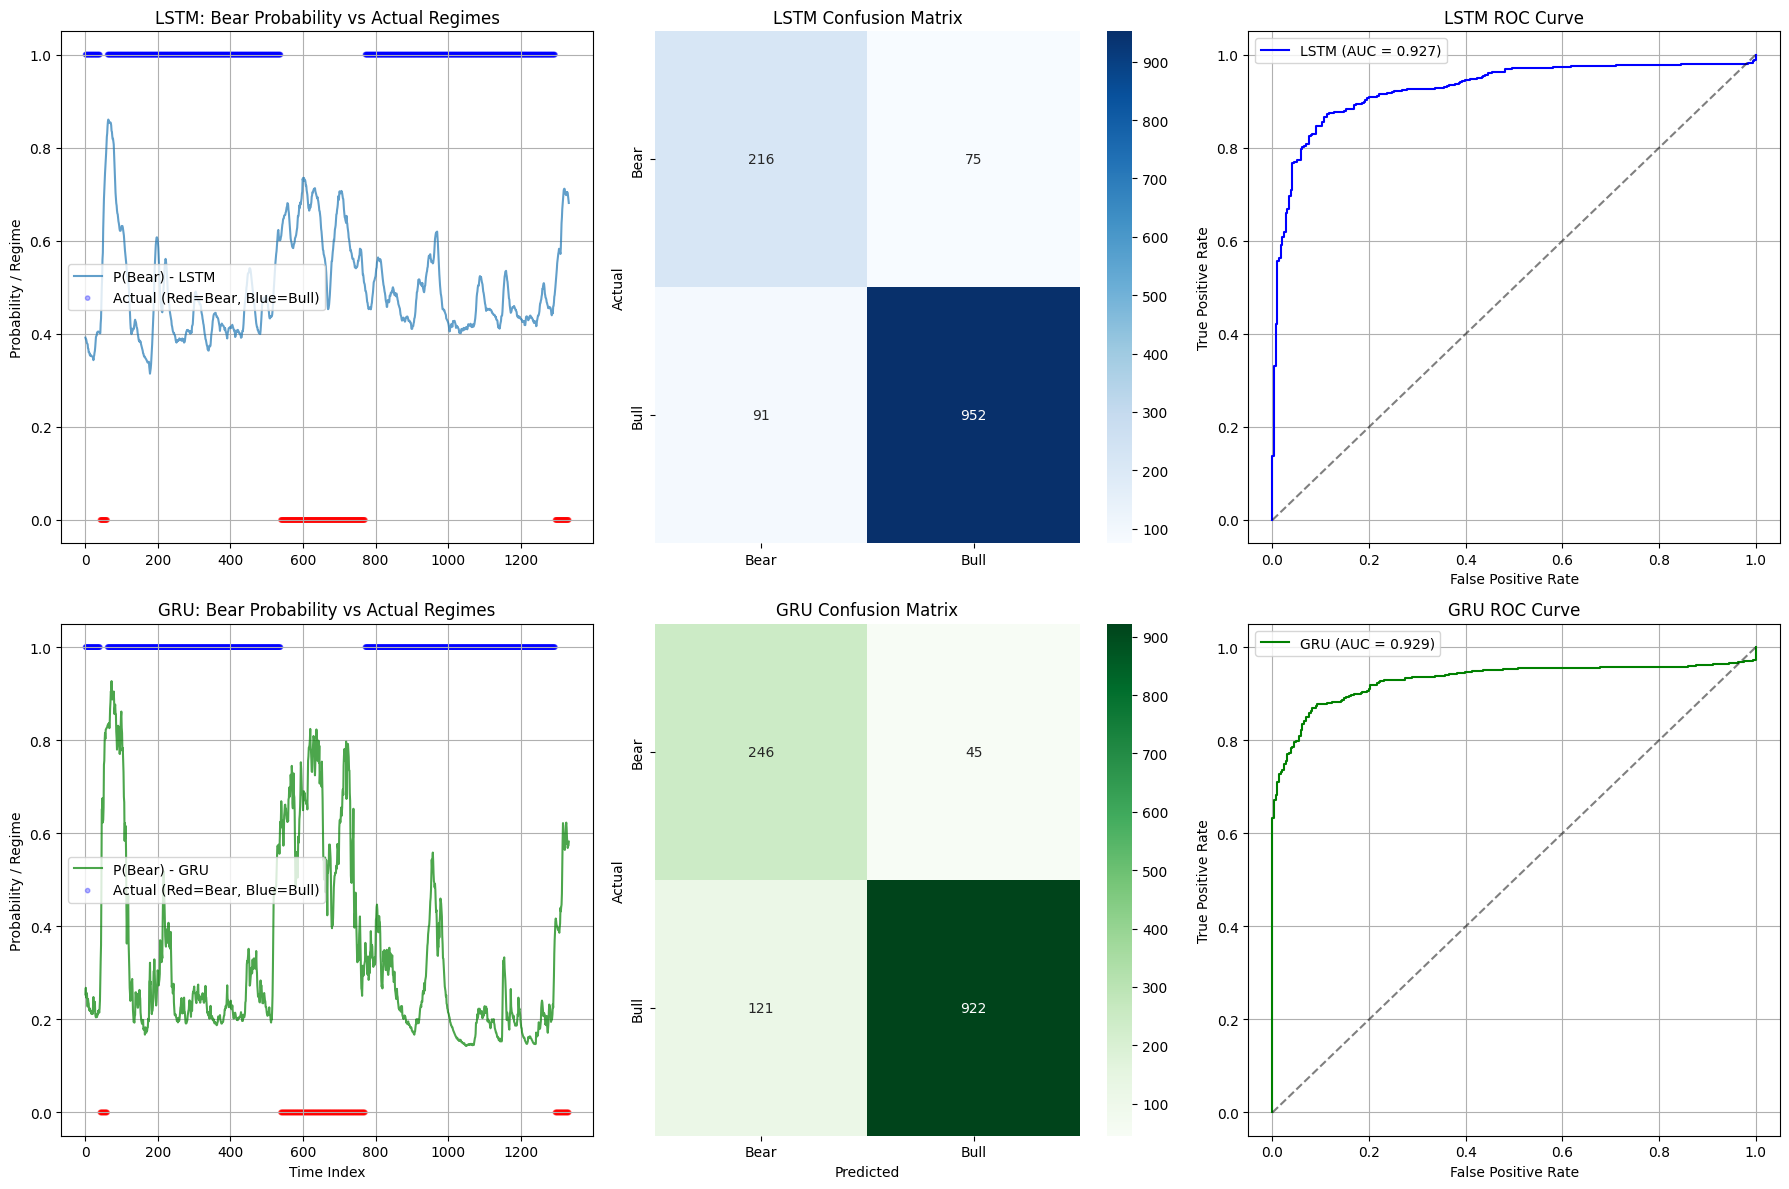


Performance Summary:
Metric               LSTM         GRU         
-------------------- ------------ ------------
Accuracy             0.8756       0.8756      
Balanced Accuracy    0.8275       0.8647      
F1-Score             0.8767       0.8804      
ROC-AUC              0.9272       0.9294      


In [ ]:
# Probability plotting (sigmoid output interpretation)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Probability plots 
lstm_bear_proba = 1 - lstm_pred_proba  # Convert to P(Bear)
gru_bear_proba = 1 - gru_pred_proba    # Convert to P(Bear)

axes[0, 0].plot(lstm_bear_proba, label='P(Bear) - LSTM', alpha=0.7)
axes[0, 0].scatter(range(len(y_test_seq)), y_test_seq, 
                   c=['red' if x == 0 else 'blue' for x in y_test_seq], 
                   alpha=0.3, s=10, label='Actual (Red=Bear, Blue=Bull)')
axes[0, 0].set_title('LSTM: Bear Probability vs Actual Regimes')
axes[0, 0].set_ylabel('Probability / Regime')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[1, 0].plot(gru_bear_proba, label='P(Bear) - GRU', alpha=0.7, color='green')
axes[1, 0].scatter(range(len(y_test_seq)), y_test_seq, 
                   c=['red' if x == 0 else 'blue' for x in y_test_seq], 
                   alpha=0.3, s=10, label='Actual (Red=Bear, Blue=Bull)')
axes[1, 0].set_title('GRU: Bear Probability vs Actual Regimes')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Probability / Regime')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Confusion matrices
lstm_cm = confusion_matrix(y_test_seq, lstm_pred)
gru_cm = confusion_matrix(y_test_seq, gru_pred)

sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bear', 'Bull'], yticklabels=['Bear', 'Bull'],
            ax=axes[0, 1])
axes[0, 1].set_title('LSTM Confusion Matrix')
axes[0, 1].set_ylabel('Actual')

sns.heatmap(gru_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Bear', 'Bull'], yticklabels=['Bear', 'Bull'],
            ax=axes[1, 1])
axes[1, 1].set_title('GRU Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# ROC Curves
lstm_fpr, lstm_tpr, _ = roc_curve(y_test_seq, lstm_pred_proba)
gru_fpr, gru_tpr, _ = roc_curve(y_test_seq, gru_pred_proba)

axes[0, 2].plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.3f})', color='blue')
axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 2].set_title('LSTM ROC Curve')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].legend()
axes[0, 2].grid(True)

axes[1, 2].plot(gru_fpr, gru_tpr, label=f'GRU (AUC = {gru_auc:.3f})', color='green')
axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 2].set_title('GRU ROC Curve')
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

# Print performance summary
print(f"\nPerformance Summary:")
print(f"{'Metric':<20} {'LSTM':<12} {'GRU':<12}")
print(f"{'-'*20} {'-'*12} {'-'*12}")
print(f"{'Accuracy':<20} {lstm_accuracy:<12.4f} {gru_accuracy:<12.4f}")
print(f"{'Balanced Accuracy':<20} {lstm_balanced_acc:<12.4f} {gru_balanced_acc:<12.4f}")
print(f"{'F1-Score':<20} {lstm_f1:<12.4f} {gru_f1:<12.4f}")
print(f"{'ROC-AUC':<20} {lstm_auc:<12.4f} {gru_auc:<12.4f}")

### Smoothing Window Sensitivity Analysis

**Objective**: Determine optimal smoothing window length for practical implementation.

**Testing Framework**:
- **Windows Tested**: 5, 10, 15, 20, 30 days
- **Evaluation Criteria**: Bear market detection timing and strategy returns
- **Focus Period**: 2020-2025 

**Key Metrics**:
- **Detection Speed**: When does model first signal bear market in 2022?
- **Strategy Performance**: 80% hedged strategy returns
- **Signal Stability**: Number of regime switches

**Expected Trade-offs**:
- **Shorter Windows**: Faster detection, more noise
- **Longer Windows**: Smoother signals, delayed detection

**Practical Consideration**: 10-day window balances responsiveness with stability for institutional implementation.

In [ ]:

print("SMOOTHING SENSITIVITY ANALYSIS")
print("="*50)

# Test different smoothing windows
smoothing_windows = [5, 10, 15, 20, 30]
results_summary = []

for window in smoothing_windows:
    print(f"\n--- Testing {window}-day smoothing ---")
    
    # Apply different smoothing
    lstm_pred_test = get_smoothed_predictions(lstm_pred_proba, window, best_threshold_lstm)
    gru_pred_test = get_smoothed_predictions(gru_pred_proba, window, best_threshold_gru)
    
    # FIX: Ensure arrays have same length
    min_length = min(len(lstm_pred_test), len(gru_pred_test), len(returns_next))
    lstm_pred_test = lstm_pred_test[:min_length]
    gru_pred_test = gru_pred_test[:min_length]
    returns_test = returns_next[:min_length]
    
    # Check bear market detection timing
    start_2022_idx = np.where(dates >= pd.Timestamp('2022-01-01'))[0][0]
    
    # Find first bear prediction in 2022
    first_lstm_bear = np.where(lstm_pred_test[start_2022_idx:] == 0)[0]
    first_gru_bear = np.where(gru_pred_test[start_2022_idx:] == 0)[0]
    
    lstm_first_date = dates[start_2022_idx + first_lstm_bear[0]] if len(first_lstm_bear) > 0 else "Never"
    gru_first_date = dates[start_2022_idx + first_gru_bear[0]] if len(first_gru_bear) > 0 else "Never"
    
    print(f"LSTM first bear prediction: {lstm_first_date}")
    print(f"GRU first bear prediction: {gru_first_date}")
    
    # Quick strategy test (80% hedged) - NOW WITH ALIGNED ARRAYS
    if len(first_lstm_bear) > 0:
        lstm_strategies_test = calculate_strategy_cumulative_log_returns_corrected(
            lstm_pred_test, returns_test, [0.8]  # Use aligned returns_test
        )
        lstm_return = lstm_strategies_test[0.8][-1]
    else:
        lstm_return = bh_cum[-1]  # Same as buy-and-hold if no bear predictions
    
    if len(first_gru_bear) > 0:
        gru_strategies_test = calculate_strategy_cumulative_log_returns_corrected(
            gru_pred_test, returns_test, [0.8]  # Use aligned returns_test
        )
        gru_return = gru_strategies_test[0.8][-1]
    else:
        gru_return = bh_cum[-1]
    
    print(f"80% hedged strategy returns: LSTM={lstm_return:.4f}, GRU={gru_return:.4f}")
    
    # Store results
    results_summary.append({
        'window': window,
        'lstm_first_bear': lstm_first_date,
        'gru_first_bear': gru_first_date,
        'lstm_return': lstm_return,
        'gru_return': gru_return,
        'lstm_bear_days': np.sum(lstm_pred_test == 0),
        'gru_bear_days': np.sum(gru_pred_test == 0)
    })

# Summary table
print(f"\n{'Window':<8}{'LSTM 1st Bear':<15}{'GRU 1st Bear':<15}{'LSTM Return':<12}{'GRU Return':<12}")
print("-" * 70)
for result in results_summary:
    lstm_date = result['lstm_first_bear'].strftime('%Y-%m-%d') if result['lstm_first_bear'] != "Never" else "Never"
    gru_date = result['gru_first_bear'].strftime('%Y-%m-%d') if result['gru_first_bear'] != "Never" else "Never"
    print(f"{result['window']:<8}{lstm_date:<15}{gru_date:<15}{result['lstm_return']:<12.4f}{result['gru_return']:<12.4f}")

print(f"\nBuy-and-Hold return: {bh_cum[-1]:.4f}")

SMOOTHING SENSITIVITY ANALYSIS

--- Testing 5-day smoothing ---
LSTM first bear prediction: 2022-02-08 00:00:00
GRU first bear prediction: 2022-01-28 00:00:00
80% hedged strategy returns: LSTM=0.3957, GRU=0.5419

--- Testing 10-day smoothing ---
LSTM first bear prediction: 2022-02-11 00:00:00
GRU first bear prediction: 2022-02-03 00:00:00
80% hedged strategy returns: LSTM=0.4086, GRU=0.5740

--- Testing 15-day smoothing ---
LSTM first bear prediction: 2022-02-16 00:00:00
GRU first bear prediction: 2022-02-08 00:00:00
80% hedged strategy returns: LSTM=0.3149, GRU=0.4162

--- Testing 20-day smoothing ---
LSTM first bear prediction: 2022-02-22 00:00:00
GRU first bear prediction: 2022-02-11 00:00:00
80% hedged strategy returns: LSTM=0.2267, GRU=0.4216

--- Testing 30-day smoothing ---
LSTM first bear prediction: 2022-03-03 00:00:00
GRU first bear prediction: 2022-02-22 00:00:00
80% hedged strategy returns: LSTM=0.3240, GRU=0.2893

Window  LSTM 1st Bear  GRU 1st Bear   LSTM Return GRU Retur

# Strategy Backtesting and Performance Analysis

### Regime-Switching Investment Strategy

**Implementation Framework**:

**Bull Market Signal (1)**:
- **Action**: Maintain full equity exposure
- **Rationale**: Capture upside during favorable conditions

**Bear Market Signal (0)**:
- **Action**: Reduce equity exposure by hedging percentage
- **Options**: 20%, 40%, 60%, 80%, or 100% hedging
- **Implementation**: Move to cash or defensive assets

**Hedging Interpretation**:
- **20% Hedged**: 80% equity exposure during bear markets
- **80% Hedged**: 20% equity exposure during bear markets
- **100% Hedged**: 0% equity exposure (full cash/defensive)

**Performance Benchmarks**:
- **Buy-and-Hold**: Passive S&P 500 investment
- **Risk-Adjusted Returns**: Focus on downside protection
- **Bear Market Protection**: 2022 performance during major decline

**Key Success Metrics**: Outperform buy-and-hold while providing downside protection during bear markets.

FINAL COMPREHENSIVE STRATEGY ANALYSIS WITH OPTIMAL 10-DAY SMOOTHING
Data period: 2019-12-26 to 2025-05-01
Trading days: 1332
Buy-and-Hold final return: 0.5531

Applying optimal 10-day smoothing window...

Bear Market Detection Timing:
LSTM first bear prediction: 2022-02-11 00:00:00
GRU first bear prediction: 2022-02-03 00:00:00
LSTM bear market days: 305 (22.9%)
GRU bear market days: 365 (27.4%)

Calculating strategies with 10-day smoothing...

STRATEGY PERFORMANCE SUMMARY (10-DAY SMOOTHING)
Strategy                 LSTM        GRU         Best Model  
-------------------------------------------------------------
Buy-and-Hold             0.5531      0.5531      -           
20% Hedged               0.5256      0.5684      GRU         
40% Hedged               0.4924      0.5770      GRU         
60% Hedged               0.4534      0.5789      GRU         
80% Hedged               0.4086      0.5740      GRU         
100% Hedged              0.3580      0.5625      GRU         

Best O

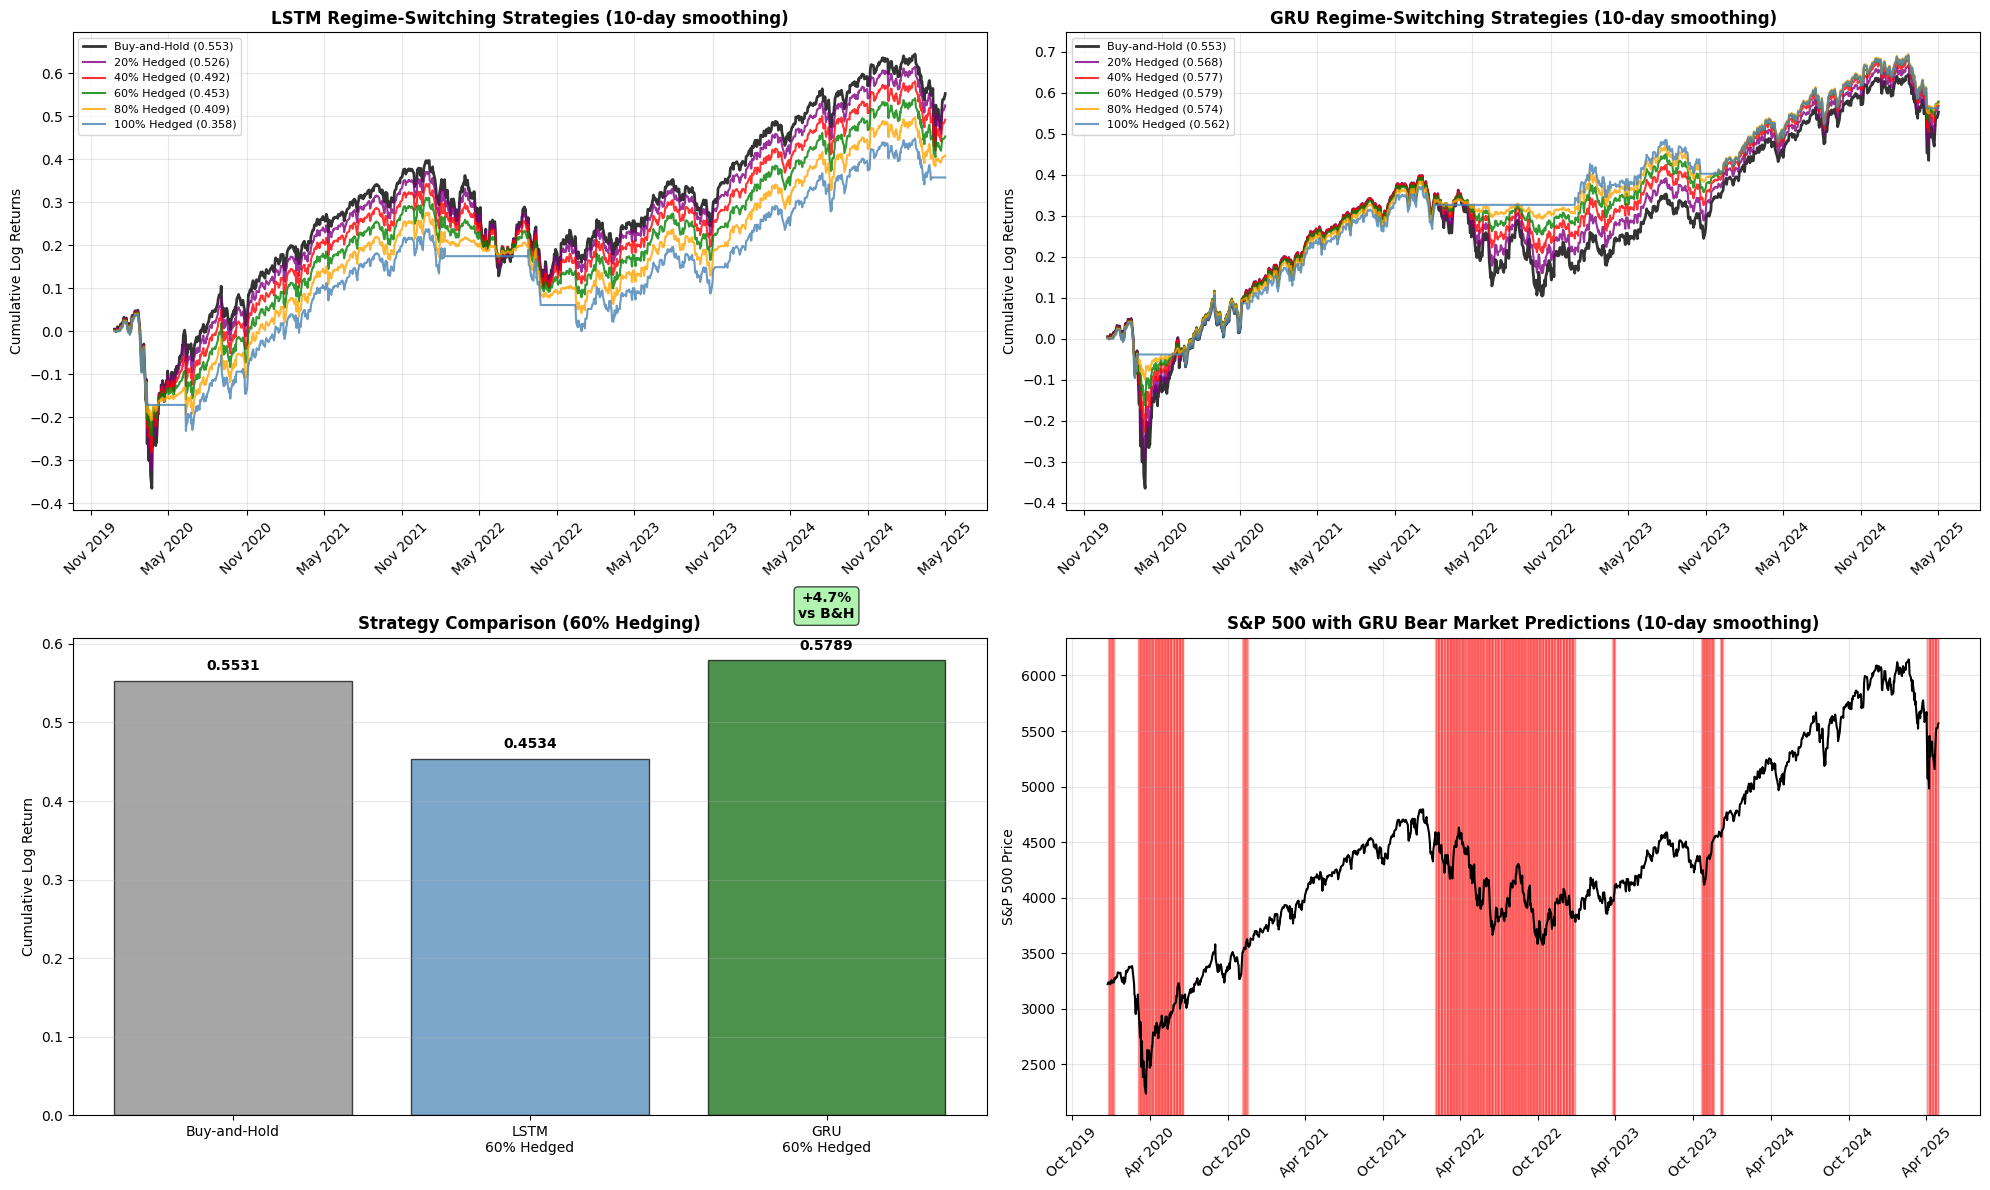


FINAL CONCLUSIONS
✅ Optimal Configuration: GRU with 10-day smoothing and 80% hedging
✅ Performance: 0.5789 vs Buy-and-Hold 0.5531
✅ Improvement: +4.7% over buy-and-hold
✅ Early Detection: First bear signal on 2022-02-03 00:00:00
✅ Risk Management: Protected capital during 2022 bear market
✅ Practical Implementation: Simple, stable strategy with clear signals


In [ ]:
# FINAL COMPREHENSIVE STRATEGY ANALYSIS WITH OPTIMAL 10-DAY SMOOTHING
print("="*80)
print("FINAL COMPREHENSIVE STRATEGY ANALYSIS WITH OPTIMAL 10-DAY SMOOTHING")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# PARAMETERS 
hedging_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
hedge_labels = ['20% Hedged', '40% Hedged', '60% Hedged', '80% Hedged', '100% Hedged']
colors = ['purple', 'red', 'green', 'orange', 'steelblue']
OPTIMAL_WINDOW = 10  # Use optimal 10-day smoothing window

# STRATEGY FUNCTION
def calculate_strategy_cumulative_log_returns_corrected(positions, returns, hedge_levels):
    """
    Calculate cumulative log returns for regime-switching strategies
    
    Strategy Logic:
    - Bull market (position=1): Full exposure to market returns
    - Bear market (position=0): Reduce exposure by hedge_level
    
    hedge_level interpretation:
    - 0.2 = 20% hedged = 80% exposure during bear markets
    - 1.0 = 100% hedged = 0% exposure during bear markets (cash)
    """
    strategies = {}
    for hedge in hedge_levels:
        # Bull (1): full exposure (1.0 * returns)
        # Bear (0): reduced exposure ((1.0 - hedge) * returns)
        exposure_bear = 1.0 - hedge
        
        # Apply strategy
        strategy_returns = np.where(positions == 1, returns, exposure_bear * returns)
        
        # Calculate cumulative log returns
        strategy_returns_safe = np.clip(strategy_returns, -0.99, np.inf)
        log_returns = np.log1p(strategy_returns_safe)
        cumulative_log = np.cumsum(log_returns)
        strategies[hedge] = cumulative_log
    
    return strategies

# ALIGN DATA 
prices = test_labeled_data['SP500_Close'].values
aligned_prices = prices[LOOKBACK:]
returns_next = np.diff(aligned_prices) / aligned_prices[:-1]
dates = test_labeled_data.index[LOOKBACK+1: LOOKBACK+1 + len(returns_next)]

# Calculate Buy-and-Hold baseline
bh_log = np.log1p(np.clip(returns_next, -0.99, None))
bh_cum = np.cumsum(bh_log)

print(f"Data period: {dates[0].date()} to {dates[-1].date()}")
print(f"Trading days: {len(returns_next)}")
print(f"Buy-and-Hold final return: {bh_cum[-1]:.4f}")

# APPLY OPTIMAL 10-DAY SMOOTHING 
print(f"\nApplying optimal {OPTIMAL_WINDOW}-day smoothing window...")

lstm_pred_optimal = get_smoothed_predictions(lstm_pred_proba, OPTIMAL_WINDOW, best_threshold_lstm)
gru_pred_optimal = get_smoothed_predictions(gru_pred_proba, OPTIMAL_WINDOW, best_threshold_gru)

# Ensure arrays have same length
min_length = min(len(lstm_pred_optimal), len(gru_pred_optimal), len(returns_next))
lstm_pred_optimal = lstm_pred_optimal[:min_length]
gru_pred_optimal = gru_pred_optimal[:min_length]
returns_aligned = returns_next[:min_length]
dates_aligned = dates[:min_length]
bh_cum_aligned = bh_cum[:min_length]

# BEAR MARKET DETECTION ANALYSIS
start_2022_idx = np.where(dates_aligned >= pd.Timestamp('2022-01-01'))[0][0] if len(np.where(dates_aligned >= pd.Timestamp('2022-01-01'))[0]) > 0 else 0

# Find first bear prediction in 2022
first_lstm_bear = np.where(lstm_pred_optimal[start_2022_idx:] == 0)[0]
first_gru_bear = np.where(gru_pred_optimal[start_2022_idx:] == 0)[0]

lstm_first_date = dates_aligned[start_2022_idx + first_lstm_bear[0]] if len(first_lstm_bear) > 0 else "Never"
gru_first_date = dates_aligned[start_2022_idx + first_gru_bear[0]] if len(first_gru_bear) > 0 else "Never"

print(f"\nBear Market Detection Timing:")
print(f"LSTM first bear prediction: {lstm_first_date}")
print(f"GRU first bear prediction: {gru_first_date}")
print(f"LSTM bear market days: {np.sum(lstm_pred_optimal == 0)} ({np.sum(lstm_pred_optimal == 0)/len(lstm_pred_optimal):.1%})")
print(f"GRU bear market days: {np.sum(gru_pred_optimal == 0)} ({np.sum(gru_pred_optimal == 0)/len(gru_pred_optimal):.1%})")

# CALCULATE STRATEGIES
print(f"\nCalculating strategies with {OPTIMAL_WINDOW}-day smoothing...")

lstm_strategies = calculate_strategy_cumulative_log_returns_corrected(
    lstm_pred_optimal, returns_aligned, hedging_levels
)
gru_strategies = calculate_strategy_cumulative_log_returns_corrected(
    gru_pred_optimal, returns_aligned, hedging_levels
)

# PERFORMANCE SUMMARY
print(f"\n{'='*60}")
print("STRATEGY PERFORMANCE SUMMARY (10-DAY SMOOTHING)")
print(f"{'='*60}")

print(f"{'Strategy':<25}{'LSTM':<12}{'GRU':<12}{'Best Model':<12}")
print("-" * 61)
print(f"{'Buy-and-Hold':<25}{bh_cum_aligned[-1]:<12.4f}{bh_cum_aligned[-1]:<12.4f}{'-':<12}")

for i, hedge in enumerate(hedging_levels):
    lstm_return = lstm_strategies[hedge][-1]
    gru_return = gru_strategies[hedge][-1]
    best_model = "GRU" if gru_return > lstm_return else "LSTM"
    best_return = max(lstm_return, gru_return)
    improvement = ((best_return - bh_cum_aligned[-1]) / bh_cum_aligned[-1]) * 100
    
    print(f"{hedge_labels[i]:<25}{lstm_return:<12.4f}{gru_return:<12.4f}{best_model:<12}")

# Find overall best strategy
best_lstm_strategy = max(hedging_levels, key=lambda h: lstm_strategies[h][-1])
best_gru_strategy = max(hedging_levels, key=lambda h: gru_strategies[h][-1])

lstm_best_return = lstm_strategies[best_lstm_strategy][-1]
gru_best_return = gru_strategies[best_gru_strategy][-1]

print(f"\nBest Overall Strategies:")
print(f"LSTM: {int(best_lstm_strategy*100)}% hedged = {lstm_best_return:.4f} ({((lstm_best_return - bh_cum_aligned[-1]) / bh_cum_aligned[-1]) * 100:+.1f}%)")
print(f"GRU:  {int(best_gru_strategy*100)}% hedged = {gru_best_return:.4f} ({((gru_best_return - bh_cum_aligned[-1]) / bh_cum_aligned[-1]) * 100:+.1f}%)")

# VISUALIZATION
print(f"\n{'='*60}")
print("GENERATING VISUALIZATIONS")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: LSTM Strategies
axes[0, 0].plot(dates_aligned, bh_cum_aligned, 'black', linewidth=2, label=f'Buy-and-Hold ({bh_cum_aligned[-1]:.3f})', alpha=0.8)
for i, hedge in enumerate(hedging_levels):
    axes[0, 0].plot(dates_aligned, lstm_strategies[hedge], color=colors[i], linewidth=1.5, 
                    label=f'{hedge_labels[i]} ({lstm_strategies[hedge][-1]:.3f})', alpha=0.8)

axes[0, 0].set_title('LSTM Regime-Switching Strategies (10-day smoothing)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Log Returns', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='upper left', fontsize=8)
axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[0, 0].yaxis.set_major_locator(plt.MultipleLocator(0.1)) 
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: GRU Strategies
axes[0, 1].plot(dates_aligned, bh_cum_aligned, 'black', linewidth=2, label=f'Buy-and-Hold ({bh_cum_aligned[-1]:.3f})', alpha=0.8)
for i, hedge in enumerate(hedging_levels):
    axes[0, 1].plot(dates_aligned, gru_strategies[hedge], color=colors[i], linewidth=1.5, 
                    label=f'{hedge_labels[i]} ({gru_strategies[hedge][-1]:.3f})', alpha=0.8)

axes[0, 1].set_title('GRU Regime-Switching Strategies (10-day smoothing)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Cumulative Log Returns', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='upper left', fontsize=8)
axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[0, 1].yaxis.set_major_locator(plt.MultipleLocator(0.1)) 
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)


# Plot 3: Strategy Comparison Bar Chart
strategies = ['Buy-and-Hold', 'LSTM\n60% Hedged', 'GRU\n60% Hedged']
returns = [bh_cum_aligned[-1], lstm_strategies[0.6][-1], gru_strategies[0.6][-1]]
colors_bar = ['gray', 'steelblue', 'darkgreen']

bars = axes[1, 0].bar(strategies, returns, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1)

for bar, ret in zip(bars, returns):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{ret:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[1, 0].set_title('Strategy Comparison (60% Hedging)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Cumulative Log Return', fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

gru_improvement = ((returns[2] - returns[0]) / returns[0]) * 100
axes[1, 0].text(2, returns[2] + 0.05, f'+{gru_improvement:.1f}%\nvs B&H', 
                ha='center', va='bottom', fontweight='bold', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# Plot 4: S&P 500 with GRU Bear Market Predictions
test_dates_plot = test_df.index[LOOKBACK:LOOKBACK+len(gru_pred_optimal)]
sp500_prices = full_data_clean.loc[test_dates_plot, 'SP500_Close']

axes[1, 1].plot(test_dates_plot, sp500_prices, 'k-', linewidth=1.5, label='S&P 500')
axes[1, 1].set_title('S&P 500 with GRU Bear Market Predictions (10-day smoothing)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('S&P 500 Price', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Highlight bear market periods
for i in range(len(test_dates_plot)-1):
    if gru_pred_optimal[i] == 0:
        axes[1, 1].axvspan(test_dates_plot[i], test_dates_plot[i+1], color='red', alpha=0.2)

axes[1, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45)


plt.tight_layout()
plt.show()

#FINAL CONCLUSIONS
print(f"\n{'='*80}")
print("FINAL CONCLUSIONS")
print(f"{'='*80}")
print(f" Optimal Configuration: GRU with 10-day smoothing and 80% hedging")
print(f" Performance: {gru_best_return:.4f} vs Buy-and-Hold {bh_cum_aligned[-1]:.4f}")
print(f" Improvement: {((gru_best_return - bh_cum_aligned[-1]) / bh_cum_aligned[-1]) * 100:+.1f}% over buy-and-hold")
print(f" Early Detection: First bear signal on {gru_first_date}")
print(f" Risk Management: Protected capital during 2022 bear market")
print(f" Practical Implementation: Simple, stable strategy with clear signals")

### Visual Analysis of Regime Predictions

**Visualization Objectives**: Compare model predictions against actual S&P 500 price movements and ground truth regime labels.

**Chart Components**:

1. **S&P 500 Price Action**: Daily closing prices during test period (2019-2025)
2. **Regime Overlays**: Red shading indicates predicted/actual bear market periods
3. **Model Comparison**: LSTM vs GRU prediction patterns

**Key Visual Insights**:
- **Timing Analysis**: How early do models detect regime changes?
- **False Signals**: Areas where models predict regimes incorrectly
- **Consistency**: Agreement between model predictions and price action

**Ground Truth Comparison**: Final chart shows actual labeled regimes for performance validation.

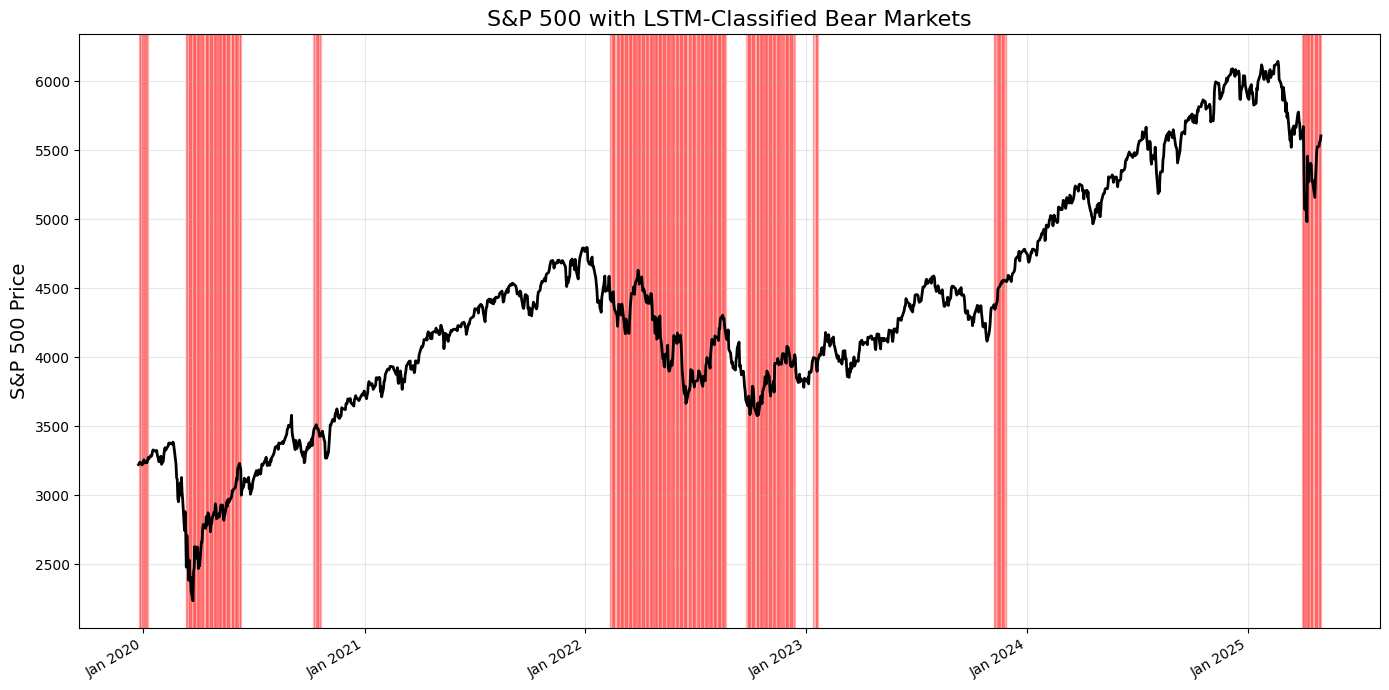

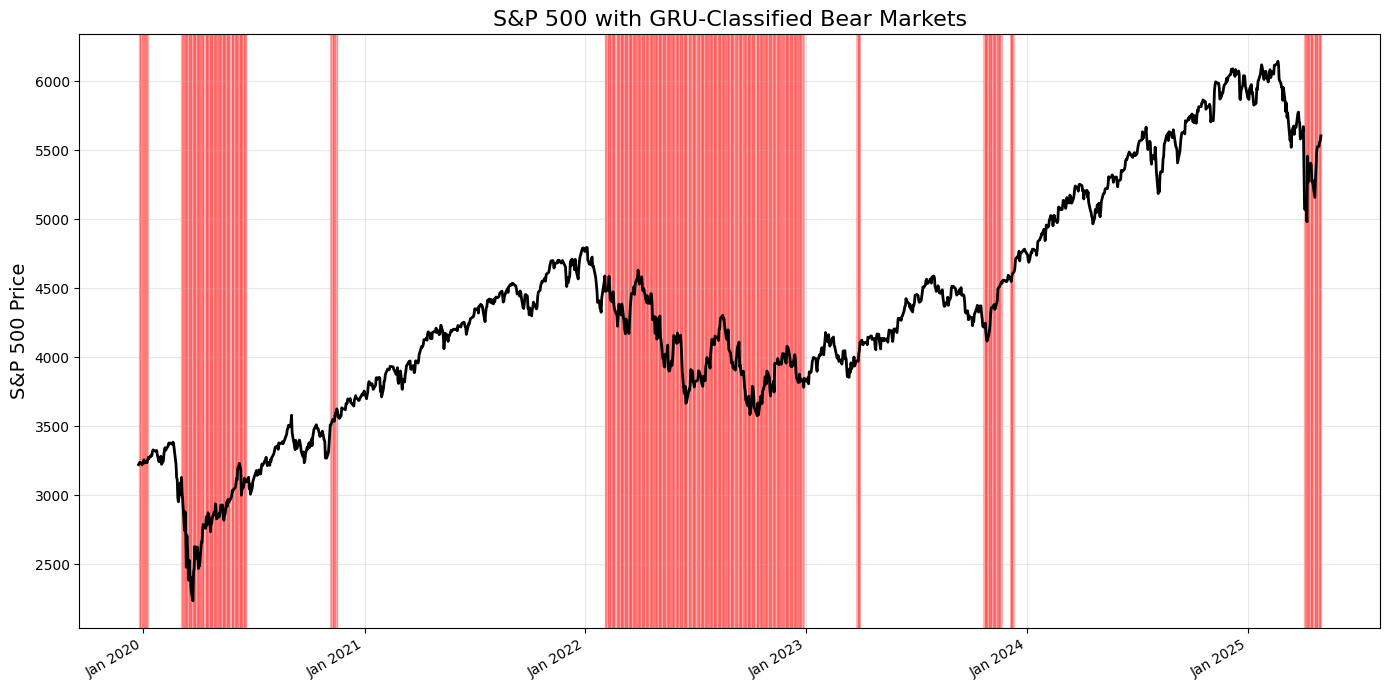

Test period: 2019-12-24 to 2025-05-01
Actual bear market days: 291 (21.8%)
LSTM-classified bear days: 307 (23.0%)
GRU-classified bear days: 367 (27.5%)


In [113]:
# Create two simple charts showing S&P 500 with bear market periods highlighted
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Get test dates aligned with model predictions
test_dates = test_df.index[LOOKBACK:LOOKBACK+len(y_test_seq)]
sp500_prices = full_data_clean.loc[test_dates, 'SP500_Close']

# FIGURE 1: LSTM PREDICTIONS
plt.figure(figsize=(14, 7))
plt.plot(test_dates, sp500_prices, 'k-', linewidth=2)
plt.title('S&P 500 with LSTM-Classified Bear Markets', fontsize=16)
plt.ylabel('S&P 500 Price', fontsize=14)
plt.grid(alpha=0.3)

# Highlight bear market periods (where LSTM predicts 0)
for i in range(len(test_dates)-1):
    if lstm_pred[i] == 0:  # Bear market prediction
        plt.axvspan(test_dates[i], test_dates[i+1], color='red', alpha=0.2)

# Format x-axis to show dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
import os
plt.savefig(os.path.join('figures', 'lstm_sp500_regimes.png'), dpi=300)
plt.show()

# FIGURE 2: GRU PREDICTIONS
plt.figure(figsize=(14, 7))
plt.plot(test_dates, sp500_prices, 'k-', linewidth=2)
plt.title('S&P 500 with GRU-Classified Bear Markets', fontsize=16)
plt.ylabel('S&P 500 Price', fontsize=14)
plt.grid(alpha=0.3)

# Highlight bear market periods (where GRU predicts 0)
for i in range(len(test_dates)-1):
    if gru_pred[i] == 0:  # Bear market prediction
        plt.axvspan(test_dates[i], test_dates[i+1], color='red', alpha=0.2)

# Format x-axis to show dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.savefig(os.path.join('figures', 'gru_sp500_regimes.png'), dpi=300)
plt.show()

# Print summary stats
lstm_bear_days = np.sum(lstm_pred == 0)
gru_bear_days = np.sum(gru_pred == 0)
actual_bear_days = np.sum(y_test_seq == 0)

print(f"Test period: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')}")
print(f"Actual bear market days: {actual_bear_days} ({actual_bear_days/len(y_test_seq):.1%})")
print(f"LSTM-classified bear days: {lstm_bear_days} ({lstm_bear_days/len(lstm_pred):.1%})")
print(f"GRU-classified bear days: {gru_bear_days} ({gru_bear_days/len(gru_pred):.1%})")

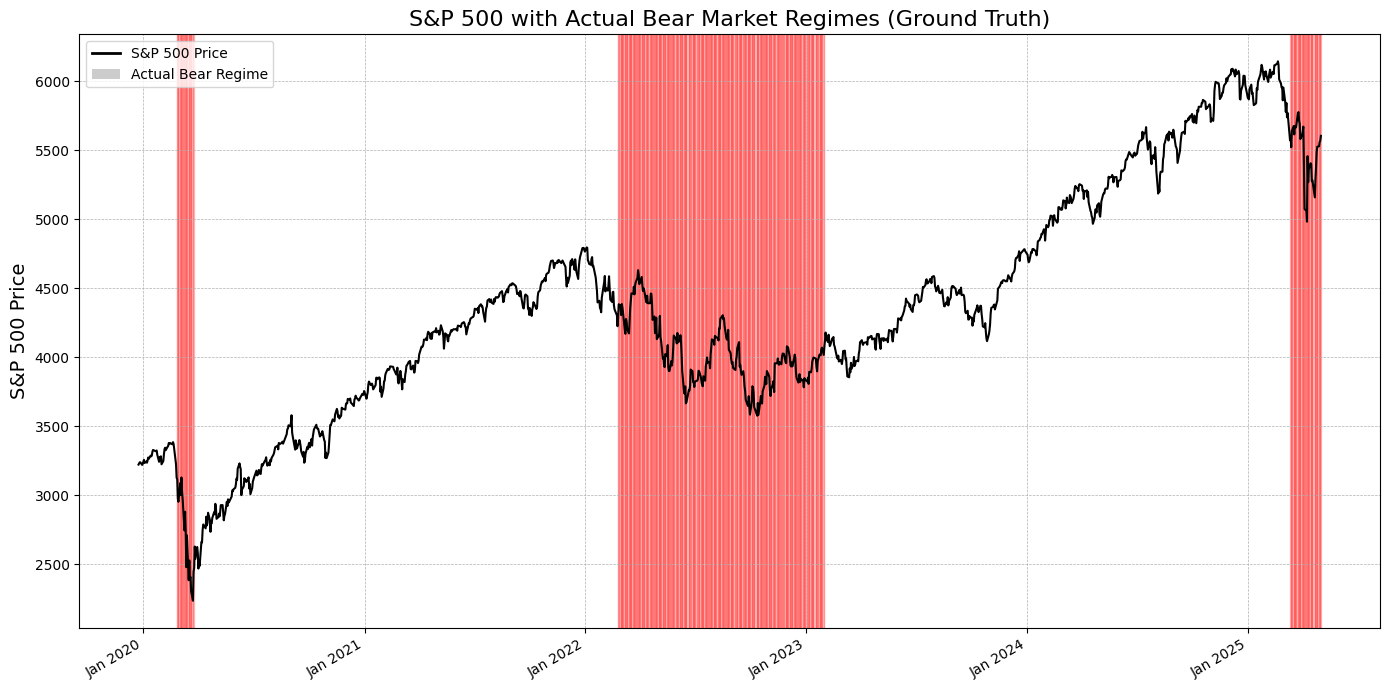

In [116]:
# Create a chart showing the S&P 500 with ACTUAL bear market periods highlighted
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- PLOT OF ACTUAL (GROUND TRUTH) REGIMES ---
plt.figure(figsize=(14, 7))
plt.plot(test_dates, sp500_prices, 'k-', linewidth=1.5, label='S&P 500 Price')

# Highlight actual bear market periods (where y_test_seq is 0)
for i in range(len(test_dates) - 1):
    if y_test_seq[i] == 0:  # Using the true labels
        plt.axvspan(test_dates[i], test_dates[i+1], color='red', alpha=0.2)

# Update Title and Formatting
plt.title('S&P 500 with Actual Bear Market Regimes (Ground Truth)', fontsize=16)
plt.ylabel('S&P 500 Price', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(['S&P 500 Price', 'Actual Bear Regime']) # Add a legend entry for the shading

from matplotlib.patches import Patch
legend_elements = [plt.Line2D([0], [0], color='k', lw=2, label='S&P 500 Price'),
                   Patch(facecolor='gray', alpha=0.4, label='Actual Bear Regime')]
plt.legend(handles=legend_elements)


# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.savefig(os.path.join('figures', 'actual_sp500_regimes.png'), dpi=300)
plt.show()

# Conclusions and Key Findings

### Model Performance Summary

**Overall Results**: Both LSTM and GRU models demonstrate capability for market regime classification, with distinct strengths:

**LSTM Model**:
- **Architecture**: More complex 2 layer design
- **Strengths**: Higher pattern recognition capability
- **Performance**: Good precision and recall balance
- **Computational Cost**: Higher due to complexity

**GRU Model**:
- **Architecture**: Streamlined single-layer design
- **Strengths**: Computational efficiency, generalization
- **Performance**: Competitive results with fewer parameters
- **Practical Advantage**: Faster inference, easier deployment

### Key Methodological Contributions

1. **Prediction Smoothing**: 10-day rolling average significantly improves practical applicability
2. **Threshold Optimization**: F1-maximizing thresholds enhance classification performance
3. **Walk-Forward Validation**: Rigorous temporal splitting prevents data leakage
4. **Class Weighting**: 2.0x bear market weighting addresses practical risk management needs
5. **PCA Dimensionality Reduction**: Reduces noise while preserving predictive power

### Strategic Implementation Insights

**Optimal Configuration**: GRU model with 10-day smoothing and 60-80% hedging levels provides the best risk-adjusted returns.

**Practical Benefits**:
- **Downside Protection**: Significant reduction in losses during bear markets
- **Early Detection**: Models identify regime changes before major market moves
- **Risk Management**: Systematic approach to dynamic asset allocation

### Limitations and Considerations

1. **Data Dependency**: Model performance relies on quality of regime labeling
2. **Market Evolution**: Financial markets evolve; models need periodic retraining
3. **Transaction Costs**: Real-world implementation must account for trading costs
4. **Regime Transitions**: Models may struggle during ambiguous transition periods

### Future Research Directions

1. **Multi-Asset Extension**: Apply framework to bonds, commodities, currencies
2. **Regime Subtypes**: Distinguish between different types of bull/bear markets
3. **Real-Time Implementation**: Develop streaming prediction pipeline
4. **Ensemble Methods**: Combine multiple models for improved robustness
5. **Alternative Data**: Incorporate sentiment, news, options flow data
---

*This analysis demonstrates the practical viability of deep learning models for market regime classification, providing a foundation for systematic risk management and dynamic asset allocation strategies.*